<a href="https://colab.research.google.com/github/alejovillores/tp2_spark_villores_alejo/blob/main/ejercicio_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio 31
Calcule la latitud y longitud promedio de los contenidos con referencias en la tierra y
diga dónde está eso

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
#!apt install default-jre
#!apt install default-jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 52.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=ff954a6bdbf64aecd06b11a1a096cb98348771894d21f3d5ad0959031f69366c
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release 

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd

In [3]:
!pip install pyarrow


In [4]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [5]:
sqlContext = SQLContext(sc)
df_geo_tags = sqlContext.read.parquet('/content/drive/MyDrive/2C2021/Datos/Trabajo Practico 2/geo_tags.csv', header=True, inferSchema=True)
rdd_contenidos = df_geo_tags.rdd

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [6]:
rdd_contenidos.count()

556393

In [7]:
rdd_contenidos.take(3)

[Row(gt_id=158041, gt_page_id=4328020, gt_globe='earth', gt_primary=0, gt_lat=41.50749969, gt_lon=-5.81750011, gt_dim=1000, gt_type=None, gt_name=None, gt_country=None, gt_region=None),
 Row(gt_id=5844377, gt_page_id=4670424, gt_globe='earth', gt_primary=0, gt_lat=13.73799992, gt_lon=-89.29199982, gt_dim=10000, gt_type='city', gt_name=None, gt_country=None, gt_region=None),
 Row(gt_id=5844381, gt_page_id=4670424, gt_globe='earth', gt_primary=0, gt_lat=13.70199966, gt_lon=-89.20800018, gt_dim=10000, gt_type='city', gt_name=None, gt_country=None, gt_region=None)]

Me quedo con aquellos registros que poseen el gt_globe en earth



In [8]:
rdd_earth = rdd_contenidos.filter(lambda x: x.gt_globe == 'earth')

In [9]:
n  = rdd_earth.count()

De esos registros, me quedo con la latitud y la longitud

In [10]:
rdd_earth_lat = rdd_earth.map(lambda x: (x.gt_globe,x.gt_lat))
rdd_earth_lon = rdd_earth.map(lambda x: (x.gt_globe,x.gt_lon))

Para evitar None, reemplazo los lat/lon con None por 0

In [11]:
cleaned_rdd_lat = rdd_earth_lat.filter(lambda x: x[1] != None)
cleaned_rdd_lon = rdd_earth_lon.filter(lambda x: x[1] != None) 

Calculo las lat y lon promedios

In [12]:
rdd_mean_lat = cleaned_rdd_lat.reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],x[1] / n))

In [13]:
rdd_mean_lon = cleaned_rdd_lon.reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],x[1] / n))

In [14]:
rdd_mean_lat.join(rdd_mean_lon).collect()

[('earth', (32.353382400123586, -24.665538716943566))]

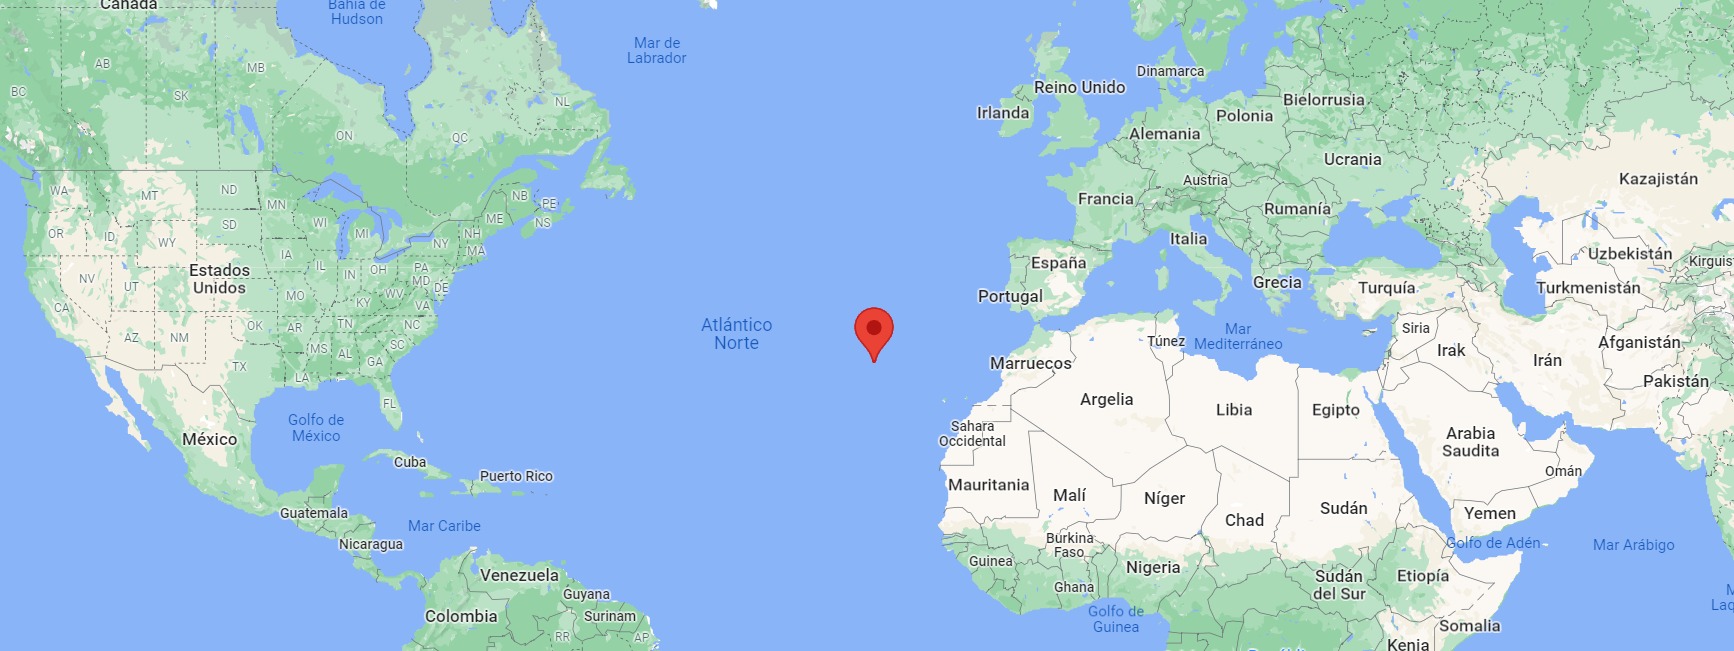